# 🎫 Support Ticket Classification & Prioritization
This notebook demonstrates an end-to-end Machine Learning pipeline for automatically classifying customer support tickets and assigning them a priority level.

## 1. Setup and Imports
We use standard NLP and ML libraries: `pandas`, `nltk`, and `scikit-learn`.

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Download resources for lemmatization and stopwords
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

## 2. Loading the Dataset
We use the Kaggle 'Customer Support Ticket Dataset'. It contains ticket subject, description, assigned category, and priority.

In [5]:
df = pd.read_csv('customer_support_tickets.csv')
# Keep relevant columns
df = df[['Ticket Description', 'Ticket Type', 'Ticket Priority']].dropna()
print(f'Total tickets loaded: {df.shape[0]}')
df.head()

Total tickets loaded: 8469


,Ticket Description,Ticket Type,Ticket Priority
0,I'm having an issue with the {product_purchase...,Technical issue,Critical
1,I'm having an issue with the {product_purchase...,Technical issue,Critical
2,I'm facing a problem with my {product_purchase...,Technical issue,Low
3,I'm having an issue with the {product_purchase...,Billing inquiry,Low
4,I'm having an issue with the {product_purchase...,Billing inquiry,Low


## 3. Data Preprocessing & NLP
We clean the text data by lowercasing, removing punctuation, stopwords, and applying lemmatization. This turns raw user input into normalized text.

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned)

df['Clean_Text'] = df['Ticket Description'].apply(clean_text)
df[['Ticket Description', 'Clean_Text']].head()

,Ticket Description,Clean_Text
0,I'm having an issue with the {product_purchase...,im issue productpurchased please assist billin...
1,I'm having an issue with the {product_purchase...,im issue productpurchased please assist need c...
2,I'm facing a problem with my {product_purchase...,im facing problem productpurchased productpurc...
3,I'm having an issue with the {product_purchase...,im issue productpurchased please assist proble...
4,I'm having an issue with the {product_purchase...,im issue productpurchased please assist note s...


## 4. Feature Extraction & Train/Test Split
Machine learning models require mathematical representations of text. We use `TfidfVectorizer` to convert cleaned text into TF-IDF scores. Then we split our data into 80% training and 20% testing.

In [7]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Clean_Text'])

y_cat = df['Ticket Type']
y_prio = df['Ticket Priority']

# Split for Category model
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Split for Priority model
X_train_prio, X_test_prio, y_train_prio, y_test_prio = train_test_split(X, y_prio, test_size=0.2, random_state=42)

## 5. Model Training
We train two separate models:
1. **Categorization**: Logistic Regression (works well for text classification).
2. **Prioritization**: Random Forest Classifier (handles non-linear correlations better, good for priority assignments).

In [8]:
# 1. Train Category Model
cat_model = LogisticRegression(max_iter=1000, random_state=42)
cat_model.fit(X_train_cat, y_train_cat)

# 2. Train Priority Model
prio_model = RandomForestClassifier(n_estimators=100, random_state=42)
prio_model.fit(X_train_prio, y_train_prio)

RandomForestClassifier(random_state=42)

## 6. Evaluation
Let's evaluate the models using accuracy, precision, and recall.

In [9]:
print('--- CATEGORY CLASSIFICATION REPORT ---')
y_pred_cat = cat_model.predict(X_test_cat)
print(f'Accuracy: {accuracy_score(y_test_cat, y_pred_cat):.2f}\n')
print(classification_report(y_test_cat, y_pred_cat))

print('\n--- PRIORITY CLASSIFICATION REPORT ---')
y_pred_prio = prio_model.predict(X_test_prio)
print(f'Accuracy: {accuracy_score(y_test_prio, y_pred_prio):.2f}\n')
print(classification_report(y_test_prio, y_pred_prio))

--- CATEGORY CLASSIFICATION REPORT ---
Accuracy: 0.20

                      precision    recall  f1-score   support

     Billing inquiry       0.16      0.10      0.12       357
Cancellation request       0.20      0.21      0.20       327
     Product inquiry       0.17      0.17      0.17       316
      Refund request       0.22      0.26      0.24       345
     Technical issue       0.23      0.26      0.24       349

            accuracy                           0.20      1694
           macro avg       0.19      0.20      0.19      1694
        weighted avg       0.19      0.20      0.19      1694


--- PRIORITY CLASSIFICATION REPORT ---
Accuracy: 0.26

              precision    recall  f1-score   support

    Critical       0.24      0.27      0.25       411
        High       0.25      0.25      0.25       409
         Low       0.26      0.23      0.24       415
      Medium       0.27      0.27      0.27       459

    accuracy                           0.26      1694
  

### Confusion Matrices
A confusion matrix shows where the model is confused (predicting one class when it is actually another).

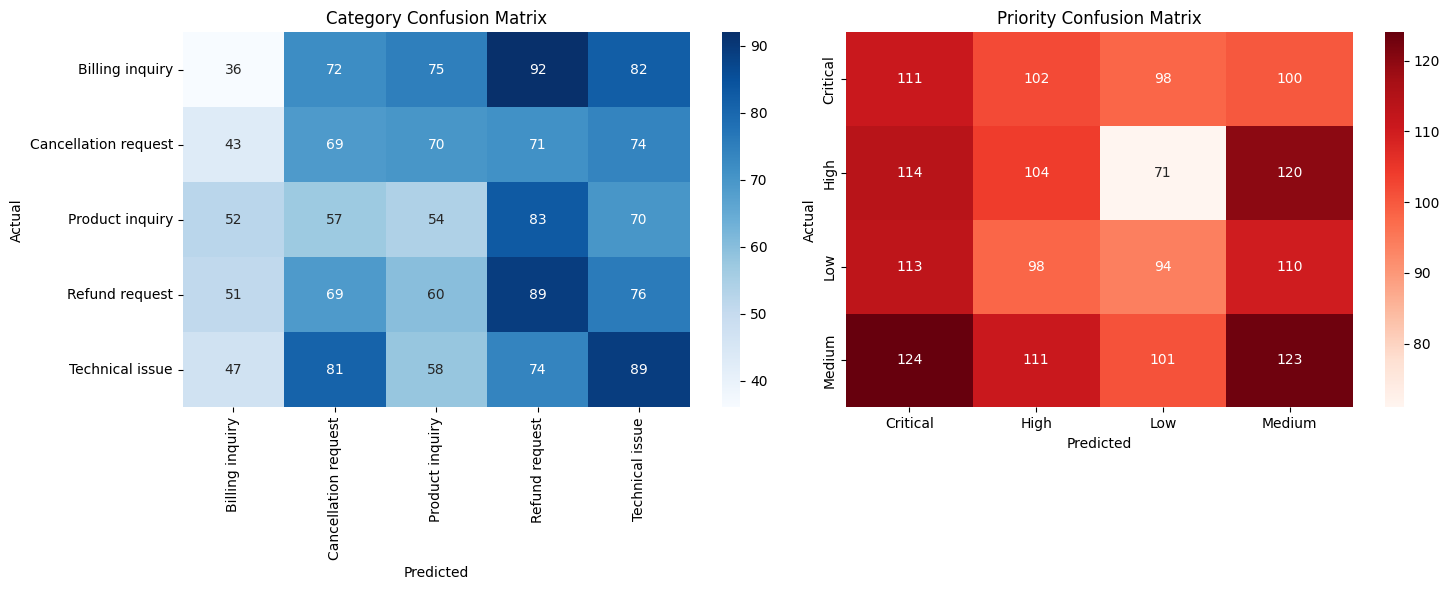

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(confusion_matrix(y_test_cat, y_pred_cat), annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=cat_model.classes_, yticklabels=cat_model.classes_)
axes[0].set_title('Category Confusion Matrix')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test_prio, y_pred_prio), annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=prio_model.classes_, yticklabels=prio_model.classes_)
axes[1].set_title('Priority Confusion Matrix')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 7. Real-time Inference Example
A function to test how a new support ticket would be handled in production:

In [11]:
def predict_ticket(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    category = cat_model.predict(vec)[0]
    priority = prio_model.predict(vec)[0]
    return {'Category': category, 'Priority': priority}

# Test Examples
print("Ticket 1:", predict_ticket("I want to cancel my subscription immediately!"))
print("Ticket 2:", predict_ticket("The screen on my newly purchased device is cracked, how do I return it?"))
print("Ticket 3:", predict_ticket("Where can I find my invoice for last month?"))

Ticket 1: {'Category': 'Billing inquiry', 'Priority': 'Medium'}
Ticket 2: {'Category': 'Billing inquiry', 'Priority': 'Low'}
Ticket 3: {'Category': 'Product inquiry', 'Priority': 'High'}
